## Setup
Import relevant libraries and read original data

In [1]:
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing

In [2]:
fraud_data = pandas.read_csv('fraud_prep.csv.gz')

## Support functions

## Data exploration

In [3]:
#How many rows of data are available?
len(fraud_data)

284807

In [4]:
#What does it look like at first glance?
fraud_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
#Is there missing data?
nan_count = 0
for c in fraud_data.columns:
    nan_count += sum(fraud_data[c].isnull())
print('The DataFrame contains',nan_count,'null values')

The DataFrame contains 0 null values


In [6]:
#What are the ranges in each column?
for c in fraud_data.columns:
    print(c)
    print(fraud_data.loc[:,c].describe(),end='\n\n')

Time
count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

V1
count    2.848070e+05
mean     1.165980e-15
std      1.958696e+00
min     -5.640751e+01
25%     -9.203734e-01
50%      1.810880e-02
75%      1.315642e+00
max      2.454930e+00
Name: V1, dtype: float64

V2
count    2.848070e+05
mean     3.416908e-16
std      1.651309e+00
min     -7.271573e+01
25%     -5.985499e-01
50%      6.548556e-02
75%      8.037239e-01
max      2.205773e+01
Name: V2, dtype: float64

V3
count    2.848070e+05
mean    -1.373150e-15
std      1.516255e+00
min     -4.832559e+01
25%     -8.903648e-01
50%      1.798463e-01
75%      1.027196e+00
max      9.382558e+00
Name: V3, dtype: float64

V4
count    2.848070e+05
mean     2.086869e-15
std      1.415869e+00
min     -5.683171e+00
25%     -8.486401e-01
50%     -1.984653e-02
75%      7.433413e-01
max      1.

All variables _V?_ are scaled to a mean close to zero and standard deviation close to 1, so not much more to do there. There's no reason to assume any of them wouldn't be relevant beforehand.

Columns _Time_ and _Amount_ have the original values, but may also help as predictors - fraudulent buyers might for example have different behaviors for different transaction amounts. One potentially interesting use for _Time_ would be binning transactions into times of the day.

Another important hint about the data is how unbalanced it is towards the 0 Class (assumed to be non-fraud), which may require additional work on certain models.

In [7]:
print('Only {:.3f}'.format(100*sum(fraud_data['Class'])/sum(fraud_data['Class'].notnull())),'% of data samples are classified into the 1 Class')

Only 0.173 % of data samples are classified into the 1 Class


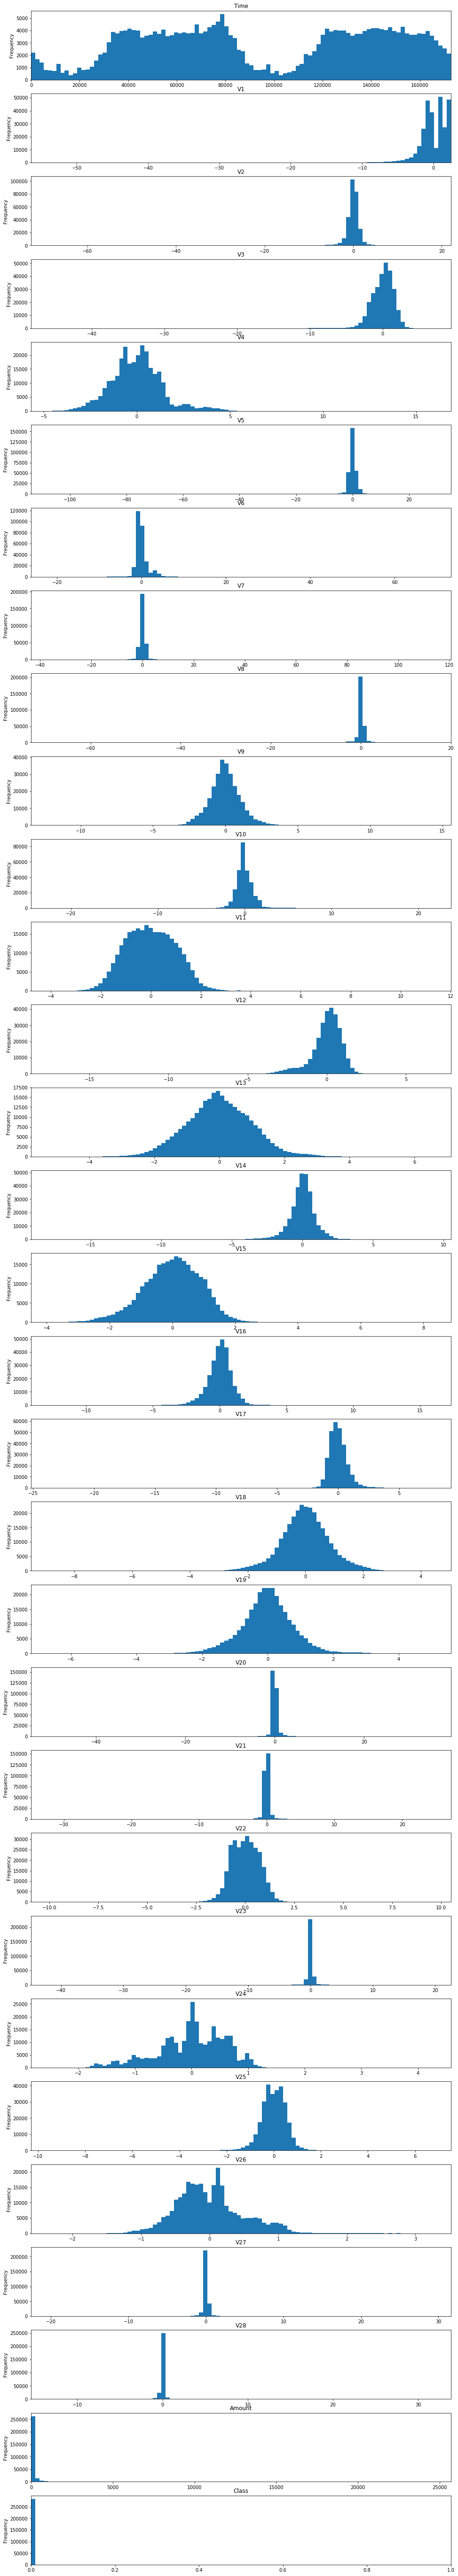

In [8]:
#What is the distribution of each variable?
fig, axes = plt.subplots(nrows=len(fraud_data.columns), ncols=1)
for i, c in enumerate(fraud_data.columns):
    fraud_data[c].plot(kind='hist', figsize=(16, 100), title=c,
                       ax=axes[i], bins=100,xlim=(fraud_data[c].min(),fraud_data[c].max()))

The charts above help make clear the presence of samples in each variable series that could be considered outliers. However without knowing what each feature represents, it is unwise to decide for removing outliers - it could have undesired effects. Outliers can after all be powerful predictors of frauds. This may also be a good hint for using *decision trees* over *logistic regression*, as the former tend to behave better with outliers.

One thing that can be noted in the chart for _Time_ above, is that there are two clear cycles of transactions, such as could be expected, for example, for the transaction volume along the day. From now on, it will be assumed then that the _Time_ column is in _seconds_, meaning the data covers a few seconds short of 2 full days of transactions. (The valleys of transaction volume most likely representing late night / early morning)

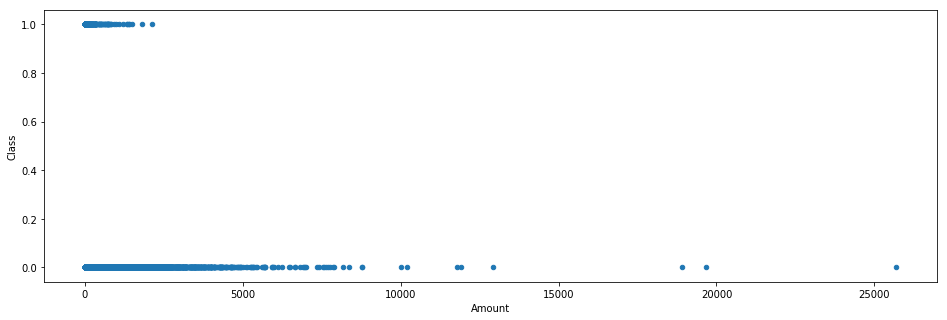

In [9]:
#Is there an apparent direct relation between _Amount_ and target _Class_?
fraud_data.plot(kind='scatter',x='Amount',y='Class',figsize=(16, 5))

In [14]:
fraud_data['Amount'][fraud_data['Class'] == 1].max()

2125.87

Except that there are no frauds with values above 2125.87, there seems to be no direct univariate correlation between _Amount_ and target _Class_.

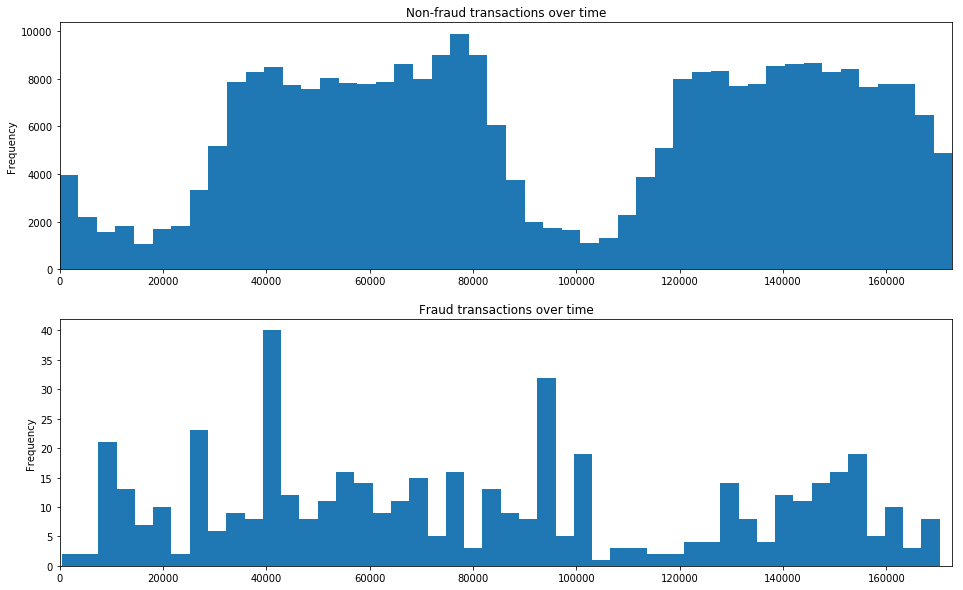

In [10]:
#Are frauds more concentrated in a certain period of the day?
fig, axes = plt.subplots(nrows=2, ncols=1)
fraud_data['Time'][fraud_data['Class']==0].plot(kind='hist', figsize=(16, 10), title='Non-fraud transactions over time',
                                                ax=axes[0], bins=48,xlim=(fraud_data['Time'].min(),fraud_data['Time'].max()))
fraud_data['Time'][fraud_data['Class']==1].plot(kind='hist', figsize=(16, 10), title='Fraud transactions over time',
                                                ax=axes[1], bins=48,xlim=(fraud_data['Time'].min(),fraud_data['Time'].max()))

There appears to be unusual fraud activity in the periods where legitimate transactions present higher volume. Binning the _Time_ data into sections of the day may therefore provide a very relevant feature!

## General feature engineering

In [11]:
feature_columns = fraud_data.columns[1:29]
work_data = fraud_data[feature_columns].copy()

In [12]:
#Scale _Amount_ feature
work_data['V29'] = preprocessing.scale(fraud_data['Amount'])

In [15]:
time = pandas.DataFrame()
time['time'] = fraud_data['Time']
time['time_in_hours'] = (time['time']/3600).astype(int)
time['day'] = (time['time_in_hours'] / 24).astype(int)
time['time_of_day'] = time['time_in_hours'] - 24*time['day']

time['time_of_day'].value_counts(sort=False)

0      7695
1      4220
2      3328
3      3492
4      2209
5      2990
6      4101
7      7243
8     10276
9     15838
10    16598
11    16856
12    15420
13    15365
14    16570
15    16461
16    16453
17    16166
18    17039
19    15649
20    16756
21    17703
22    15441
23    10938
Name: time_of_day, dtype: int64

Instead of using this feature as it is, some models may benefit from having a feature centered around the period of highest activity, with the lowest activity at the extremes. As the lowest activity occurs between 4:00 and 5:00, we'll center the new feature at the value of 16 (12 being the _natural_ center, plus the 4 hours to match the lowest activity).

In [16]:
time['distance_to_16'] = time['time_of_day'] - 16 + 24*(time['time_of_day']<4)

In [19]:
#Add feature for time of day
work_data['V30'] = preprocessing.scale(time['distance_to_16'].astype(float))

In [20]:
##Add target
work_data['target'] = fraud_data['Class'].copy()

In [21]:
work_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,target
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,1.563225,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,1.563225,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,1.563225,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,1.563225,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,1.563225,0


## Dataset split

In [ ]:
#unbalanced dataset

## Models training

## Models comparison

## Unsupervised next steps